In [ ]:
import gc
import torch

# Tüm gereksiz değişkenleri temizle
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch

# GPU belleğini boşalt
torch.cuda.empty_cache()

# CUDA bellek tahsislerini sıfırla
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, SEWModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tqdm import tqdm
import pickle
import torch.nn.functional as F
import numpy as np
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, target_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        file_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.squeeze()

        # Eğer ses uzunluğu `target_length`'den küçükse, padding ekle
        if waveform.size(0) < self.target_length:
            waveform = F.pad(waveform, (0, self.target_length - waveform.size(0)))
        else:
            waveform = waveform[:self.target_length]

        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values[0], label

def load_data(base_dir, categories, notes):
    file_paths, labels = [], []
    label_map = {note: idx for idx, note in enumerate(notes)}

    for category in categories:
        for note in notes:
            path = os.path.join(base_dir, category, note)
            if not os.path.exists(path):
                print(f"Warning: {path} does not exist.")
                continue
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
            file_paths.extend(files)
            labels.extend([label_map[note]] * len(files))
    return file_paths, labels

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return inputs_padded, torch.tensor(labels)

# Global variable for tracking the best accuracy
best_accuracy = 0

def train_model(train_loader, val_loader, model, processor, epochs=200, output_dir="model/sew"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.to(device)

    metrics_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # Get the model outputs and extract logits
                outputs = model(inputs).last_hidden_state
                logits = outputs[:, 0, :]  # For sequence classification tasks, logits are often in the first token's hidden state

                loss = loss_fn(logits, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                train_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
                pbar.update(1)

        # Compute training accuracy and loss
        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0
        val_targets, val_preds = [], []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).last_hidden_state
                logits = outputs[:, 0, :]  # Extract logits

                loss = loss_fn(logits, labels)
                total_val_loss += loss.item()
                val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(F.softmax(logits, dim=1).cpu().numpy())

        # Calculate validation accuracy and loss
        val_accuracy = accuracy_score(val_targets, val_preds)
        precision = precision_score(val_targets, val_preds, average="weighted", zero_division=1)
        recall = recall_score(val_targets, val_preds, average="weighted", zero_division=1)
        f1 = f1_score(val_targets, val_preds, average="weighted", zero_division=1)

        # Compute ROC and AUC
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(12):  # Update num_labels to 12
            fpr[i], tpr[i], _ = roc_curve(val_targets, np.array(val_probs)[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Calculate Macro ROC AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(12)]))  # Update num_labels to 12
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(12):  # Update num_labels to 12
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= 12  # Update num_labels to 12
        macro_roc_auc = auc(all_fpr, mean_tpr)

        # Save metrics for TPR and FPR
        metrics = {
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": total_train_loss,
            "val_loss": total_val_loss,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "macro_roc_auc": macro_roc_auc,
            "fpr": fpr,  # Save FPR for each class
            "tpr": tpr,  # Save TPR for each class
        }

        metrics_history.append(metrics)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Macro ROC AUC: {macro_roc_auc:.4f}")

        save_model_and_metrics(model, epoch, metrics_history, output_dir, val_accuracy)


def save_model_and_metrics(model, epoch, metrics_history, output_dir, accuracy):
    global best_accuracy  # Ensure this is the global variable

    # Klasörlerin olup olmadığını kontrol et ve oluştur
    model_output_dir = os.path.join(output_dir, "sew")
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)

    # .best.pt sadece en iyi doğrulukla kaydedilecek
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(model_output_dir, "sew_best.pt"))

    # .last.pt her zaman son epoch'la kaydedilecek
    torch.save(model.state_dict(), os.path.join(model_output_dir, "sew_last.pt"))

    # Metrikleri kaydet
    with open(os.path.join(model_output_dir, "metrics.pkl"), "wb") as f:
        pickle.dump(metrics_history, f)


# Google Drive'daki 'model/sew' klasörünü kullanacak şekilde güncelleme
base_dir = "/content/drive/MyDrive/processed"  # MyDrive altında 'processed' klasörünüz var

train_audio_paths, train_labels = load_data(os.path.join(base_dir, "train"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])
val_audio_paths, val_labels = load_data(os.path.join(base_dir, "val"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

processor = AutoProcessor.from_pretrained("asapp/sew-tiny-100k-ft-ls100h")
model = SEWModel.from_pretrained("asapp/sew-tiny-100k-ft-ls100h")
model.config.num_labels = 12  # Bu satırla modelin num_labels parametresini 12 yapıyoruz

train_dataset = AudioDataset(train_audio_paths, train_labels, processor)
val_dataset = AudioDataset(val_audio_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model çıktısını MyDrive'da 'model/sew' klasörüne kaydetme
output_dir = "/content/drive/MyDrive/model"
train_model(train_loader, val_loader, model, processor, epochs=200, output_dir=output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 1: Train Loss: 296.8590, Train Accuracy: 0.0277
Epoch 1: Train Loss: 296.8590, Train Accuracy: 0.0277, Validation Loss: 60.0878, Validation Accuracy: 0.0598, Macro ROC AUC: 0.4981


Epoch 2/200: 100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


Epoch 2: Train Loss: 202.1868, Train Accuracy: 0.0666
Epoch 2: Train Loss: 202.1868, Train Accuracy: 0.0666, Validation Loss: 44.0392, Validation Accuracy: 0.0694, Macro ROC AUC: 0.4881


Epoch 3/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 3: Train Loss: 166.3759, Train Accuracy: 0.0875
Epoch 3: Train Loss: 166.3759, Train Accuracy: 0.0875, Validation Loss: 41.3222, Validation Accuracy: 0.0837, Macro ROC AUC: 0.4936


Epoch 4/200: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


Epoch 4: Train Loss: 158.8001, Train Accuracy: 0.0912
Epoch 4: Train Loss: 158.8001, Train Accuracy: 0.0912, Validation Loss: 39.8454, Validation Accuracy: 0.0933, Macro ROC AUC: 0.5010


Epoch 5/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 5: Train Loss: 148.9656, Train Accuracy: 0.0949
Epoch 5: Train Loss: 148.9656, Train Accuracy: 0.0949, Validation Loss: 39.2155, Validation Accuracy: 0.1053, Macro ROC AUC: 0.5177


Epoch 6/200: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


Epoch 6: Train Loss: 146.4545, Train Accuracy: 0.0851
Epoch 6: Train Loss: 146.4545, Train Accuracy: 0.0851, Validation Loss: 38.2935, Validation Accuracy: 0.1124, Macro ROC AUC: 0.5287


Epoch 7/200: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


Epoch 7: Train Loss: 149.0408, Train Accuracy: 0.1017
Epoch 7: Train Loss: 149.0408, Train Accuracy: 0.1017, Validation Loss: 37.9061, Validation Accuracy: 0.0813, Macro ROC AUC: 0.5571


Epoch 8/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 8: Train Loss: 142.0761, Train Accuracy: 0.1153
Epoch 8: Train Loss: 142.0761, Train Accuracy: 0.1153, Validation Loss: 37.5377, Validation Accuracy: 0.1100, Macro ROC AUC: 0.5944


Epoch 9/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 9: Train Loss: 140.0342, Train Accuracy: 0.1196
Epoch 9: Train Loss: 140.0342, Train Accuracy: 0.1196, Validation Loss: 36.8218, Validation Accuracy: 0.1411, Macro ROC AUC: 0.6351


Epoch 10/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 10: Train Loss: 133.4829, Train Accuracy: 0.1492
Epoch 10: Train Loss: 133.4829, Train Accuracy: 0.1492, Validation Loss: 35.1776, Validation Accuracy: 0.1507, Macro ROC AUC: 0.6839


Epoch 11/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 11: Train Loss: 129.0315, Train Accuracy: 0.1504
Epoch 11: Train Loss: 129.0315, Train Accuracy: 0.1504, Validation Loss: 33.6713, Validation Accuracy: 0.1746, Macro ROC AUC: 0.7442


Epoch 12/200: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


Epoch 12: Train Loss: 121.7004, Train Accuracy: 0.1979
Epoch 12: Train Loss: 121.7004, Train Accuracy: 0.1979, Validation Loss: 30.8341, Validation Accuracy: 0.2033, Macro ROC AUC: 0.7836


Epoch 13/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 13: Train Loss: 115.5174, Train Accuracy: 0.2164
Epoch 13: Train Loss: 115.5174, Train Accuracy: 0.2164, Validation Loss: 29.7182, Validation Accuracy: 0.2177, Macro ROC AUC: 0.8153


Epoch 14/200: 100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


Epoch 14: Train Loss: 104.7660, Train Accuracy: 0.2485
Epoch 14: Train Loss: 104.7660, Train Accuracy: 0.2485, Validation Loss: 28.5294, Validation Accuracy: 0.2273, Macro ROC AUC: 0.8423


Epoch 15/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 15: Train Loss: 99.7785, Train Accuracy: 0.2737
Epoch 15: Train Loss: 99.7785, Train Accuracy: 0.2737, Validation Loss: 25.9001, Validation Accuracy: 0.2656, Macro ROC AUC: 0.8617


Epoch 16/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 16: Train Loss: 96.3970, Train Accuracy: 0.2910
Epoch 16: Train Loss: 96.3970, Train Accuracy: 0.2910, Validation Loss: 23.7666, Validation Accuracy: 0.2919, Macro ROC AUC: 0.8802


Epoch 17/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 17: Train Loss: 86.3804, Train Accuracy: 0.3354
Epoch 17: Train Loss: 86.3804, Train Accuracy: 0.3354, Validation Loss: 22.3705, Validation Accuracy: 0.3445, Macro ROC AUC: 0.8937


Epoch 18/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 18: Train Loss: 82.2299, Train Accuracy: 0.3459
Epoch 18: Train Loss: 82.2299, Train Accuracy: 0.3459, Validation Loss: 21.4891, Validation Accuracy: 0.3541, Macro ROC AUC: 0.9001


Epoch 19/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 19: Train Loss: 81.4836, Train Accuracy: 0.3397
Epoch 19: Train Loss: 81.4836, Train Accuracy: 0.3397, Validation Loss: 24.0867, Validation Accuracy: 0.3014, Macro ROC AUC: 0.8820


Epoch 20/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 20: Train Loss: 85.0319, Train Accuracy: 0.3446
Epoch 20: Train Loss: 85.0319, Train Accuracy: 0.3446, Validation Loss: 20.5406, Validation Accuracy: 0.3421, Macro ROC AUC: 0.8971


Epoch 21/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 21: Train Loss: 77.1607, Train Accuracy: 0.3687
Epoch 21: Train Loss: 77.1607, Train Accuracy: 0.3687, Validation Loss: 20.3171, Validation Accuracy: 0.3660, Macro ROC AUC: 0.9070


Epoch 22/200: 100%|██████████| 51/51 [00:31<00:00,  1.61it/s]


Epoch 22: Train Loss: 76.9751, Train Accuracy: 0.3607
Epoch 22: Train Loss: 76.9751, Train Accuracy: 0.3607, Validation Loss: 20.0946, Validation Accuracy: 0.3708, Macro ROC AUC: 0.9048


Epoch 23/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 23: Train Loss: 72.6115, Train Accuracy: 0.3847
Epoch 23: Train Loss: 72.6115, Train Accuracy: 0.3847, Validation Loss: 20.8401, Validation Accuracy: 0.3684, Macro ROC AUC: 0.9042


Epoch 24/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 24: Train Loss: 68.7454, Train Accuracy: 0.3970
Epoch 24: Train Loss: 68.7454, Train Accuracy: 0.3970, Validation Loss: 19.6176, Validation Accuracy: 0.3947, Macro ROC AUC: 0.9089


Epoch 25/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 25: Train Loss: 70.6175, Train Accuracy: 0.3927
Epoch 25: Train Loss: 70.6175, Train Accuracy: 0.3927, Validation Loss: 18.9903, Validation Accuracy: 0.4067, Macro ROC AUC: 0.9169


Epoch 26/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 26: Train Loss: 69.6611, Train Accuracy: 0.4260
Epoch 26: Train Loss: 69.6611, Train Accuracy: 0.4260, Validation Loss: 20.7042, Validation Accuracy: 0.3780, Macro ROC AUC: 0.9099


Epoch 27/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 27: Train Loss: 66.0734, Train Accuracy: 0.4229
Epoch 27: Train Loss: 66.0734, Train Accuracy: 0.4229, Validation Loss: 19.4848, Validation Accuracy: 0.4115, Macro ROC AUC: 0.9172


Epoch 28/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 28: Train Loss: 68.2105, Train Accuracy: 0.3915
Epoch 28: Train Loss: 68.2105, Train Accuracy: 0.3915, Validation Loss: 20.8622, Validation Accuracy: 0.3732, Macro ROC AUC: 0.9048


Epoch 29/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 29: Train Loss: 63.3446, Train Accuracy: 0.4334
Epoch 29: Train Loss: 63.3446, Train Accuracy: 0.4334, Validation Loss: 18.5661, Validation Accuracy: 0.4378, Macro ROC AUC: 0.9198


Epoch 30/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 30: Train Loss: 65.5073, Train Accuracy: 0.4236
Epoch 30: Train Loss: 65.5073, Train Accuracy: 0.4236, Validation Loss: 19.1308, Validation Accuracy: 0.4234, Macro ROC AUC: 0.9151


Epoch 31/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 31: Train Loss: 61.5538, Train Accuracy: 0.4513
Epoch 31: Train Loss: 61.5538, Train Accuracy: 0.4513, Validation Loss: 17.6676, Validation Accuracy: 0.4258, Macro ROC AUC: 0.9232


Epoch 32/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 32: Train Loss: 60.5295, Train Accuracy: 0.4686
Epoch 32: Train Loss: 60.5295, Train Accuracy: 0.4686, Validation Loss: 19.9951, Validation Accuracy: 0.4498, Macro ROC AUC: 0.9220


Epoch 33/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 33: Train Loss: 61.4562, Train Accuracy: 0.4519
Epoch 33: Train Loss: 61.4562, Train Accuracy: 0.4519, Validation Loss: 18.0257, Validation Accuracy: 0.4115, Macro ROC AUC: 0.9261


Epoch 34/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 34: Train Loss: 58.4578, Train Accuracy: 0.4914
Epoch 34: Train Loss: 58.4578, Train Accuracy: 0.4914, Validation Loss: 17.2918, Validation Accuracy: 0.4330, Macro ROC AUC: 0.9291


Epoch 35/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 35: Train Loss: 60.4683, Train Accuracy: 0.4784
Epoch 35: Train Loss: 60.4683, Train Accuracy: 0.4784, Validation Loss: 18.5947, Validation Accuracy: 0.3971, Macro ROC AUC: 0.9187


Epoch 36/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 36: Train Loss: 55.6108, Train Accuracy: 0.4988
Epoch 36: Train Loss: 55.6108, Train Accuracy: 0.4988, Validation Loss: 19.6437, Validation Accuracy: 0.4019, Macro ROC AUC: 0.9152


Epoch 37/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 37: Train Loss: 59.8086, Train Accuracy: 0.4827
Epoch 37: Train Loss: 59.8086, Train Accuracy: 0.4827, Validation Loss: 16.5972, Validation Accuracy: 0.4737, Macro ROC AUC: 0.9319


Epoch 38/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 38: Train Loss: 60.1177, Train Accuracy: 0.4716
Epoch 38: Train Loss: 60.1177, Train Accuracy: 0.4716, Validation Loss: 17.1045, Validation Accuracy: 0.4426, Macro ROC AUC: 0.9298


Epoch 39/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 39: Train Loss: 54.4321, Train Accuracy: 0.5284
Epoch 39: Train Loss: 54.4321, Train Accuracy: 0.5284, Validation Loss: 16.9654, Validation Accuracy: 0.4713, Macro ROC AUC: 0.9324


Epoch 40/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 40: Train Loss: 53.8190, Train Accuracy: 0.5333
Epoch 40: Train Loss: 53.8190, Train Accuracy: 0.5333, Validation Loss: 17.7124, Validation Accuracy: 0.4450, Macro ROC AUC: 0.9293


Epoch 41/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 41: Train Loss: 56.6275, Train Accuracy: 0.5160
Epoch 41: Train Loss: 56.6275, Train Accuracy: 0.5160, Validation Loss: 15.3416, Validation Accuracy: 0.4856, Macro ROC AUC: 0.9440


Epoch 42/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 42: Train Loss: 51.3596, Train Accuracy: 0.5462
Epoch 42: Train Loss: 51.3596, Train Accuracy: 0.5462, Validation Loss: 14.8043, Validation Accuracy: 0.5407, Macro ROC AUC: 0.9448


Epoch 43/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 43: Train Loss: 54.1517, Train Accuracy: 0.5314
Epoch 43: Train Loss: 54.1517, Train Accuracy: 0.5314, Validation Loss: 16.0174, Validation Accuracy: 0.5096, Macro ROC AUC: 0.9370


Epoch 44/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 44: Train Loss: 51.2276, Train Accuracy: 0.5469
Epoch 44: Train Loss: 51.2276, Train Accuracy: 0.5469, Validation Loss: 15.1720, Validation Accuracy: 0.5239, Macro ROC AUC: 0.9437


Epoch 45/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 45: Train Loss: 50.2591, Train Accuracy: 0.5629
Epoch 45: Train Loss: 50.2591, Train Accuracy: 0.5629, Validation Loss: 15.6905, Validation Accuracy: 0.4928, Macro ROC AUC: 0.9432


Epoch 46/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 46: Train Loss: 50.5089, Train Accuracy: 0.5475
Epoch 46: Train Loss: 50.5089, Train Accuracy: 0.5475, Validation Loss: 15.6854, Validation Accuracy: 0.5335, Macro ROC AUC: 0.9424


Epoch 47/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 47: Train Loss: 48.5521, Train Accuracy: 0.5820
Epoch 47: Train Loss: 48.5521, Train Accuracy: 0.5820, Validation Loss: 18.0050, Validation Accuracy: 0.4569, Macro ROC AUC: 0.9357


Epoch 48/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 48: Train Loss: 47.4571, Train Accuracy: 0.5857
Epoch 48: Train Loss: 47.4571, Train Accuracy: 0.5857, Validation Loss: 14.6437, Validation Accuracy: 0.5670, Macro ROC AUC: 0.9478


Epoch 49/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 49: Train Loss: 50.0105, Train Accuracy: 0.5586
Epoch 49: Train Loss: 50.0105, Train Accuracy: 0.5586, Validation Loss: 15.5629, Validation Accuracy: 0.5144, Macro ROC AUC: 0.9444


Epoch 50/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 50: Train Loss: 48.1205, Train Accuracy: 0.5845
Epoch 50: Train Loss: 48.1205, Train Accuracy: 0.5845, Validation Loss: 14.3476, Validation Accuracy: 0.5311, Macro ROC AUC: 0.9477


Epoch 51/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 51: Train Loss: 48.4754, Train Accuracy: 0.5863
Epoch 51: Train Loss: 48.4754, Train Accuracy: 0.5863, Validation Loss: 14.8606, Validation Accuracy: 0.5311, Macro ROC AUC: 0.9459


Epoch 52/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 52: Train Loss: 49.6189, Train Accuracy: 0.5771
Epoch 52: Train Loss: 49.6189, Train Accuracy: 0.5771, Validation Loss: 15.7971, Validation Accuracy: 0.5000, Macro ROC AUC: 0.9464


Epoch 53/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 53: Train Loss: 44.7455, Train Accuracy: 0.6245
Epoch 53: Train Loss: 44.7455, Train Accuracy: 0.6245, Validation Loss: 14.5147, Validation Accuracy: 0.5550, Macro ROC AUC: 0.9489


Epoch 54/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 54: Train Loss: 45.2685, Train Accuracy: 0.6110
Epoch 54: Train Loss: 45.2685, Train Accuracy: 0.6110, Validation Loss: 16.9246, Validation Accuracy: 0.5144, Macro ROC AUC: 0.9408


Epoch 55/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 55: Train Loss: 43.9401, Train Accuracy: 0.6208
Epoch 55: Train Loss: 43.9401, Train Accuracy: 0.6208, Validation Loss: 16.2528, Validation Accuracy: 0.5024, Macro ROC AUC: 0.9421


Epoch 56/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 56: Train Loss: 45.1003, Train Accuracy: 0.6227
Epoch 56: Train Loss: 45.1003, Train Accuracy: 0.6227, Validation Loss: 12.7396, Validation Accuracy: 0.5622, Macro ROC AUC: 0.9591


Epoch 57/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 57: Train Loss: 44.5816, Train Accuracy: 0.6110
Epoch 57: Train Loss: 44.5816, Train Accuracy: 0.6110, Validation Loss: 13.9177, Validation Accuracy: 0.5502, Macro ROC AUC: 0.9519


Epoch 58/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 58: Train Loss: 45.0312, Train Accuracy: 0.6178
Epoch 58: Train Loss: 45.0312, Train Accuracy: 0.6178, Validation Loss: 14.9542, Validation Accuracy: 0.5120, Macro ROC AUC: 0.9504


Epoch 59/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 59: Train Loss: 45.6479, Train Accuracy: 0.6171
Epoch 59: Train Loss: 45.6479, Train Accuracy: 0.6171, Validation Loss: 14.1379, Validation Accuracy: 0.5718, Macro ROC AUC: 0.9529


Epoch 60/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 60: Train Loss: 40.9100, Train Accuracy: 0.6609
Epoch 60: Train Loss: 40.9100, Train Accuracy: 0.6609, Validation Loss: 15.9912, Validation Accuracy: 0.5646, Macro ROC AUC: 0.9540


Epoch 61/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 61: Train Loss: 42.2115, Train Accuracy: 0.6597
Epoch 61: Train Loss: 42.2115, Train Accuracy: 0.6597, Validation Loss: 13.4064, Validation Accuracy: 0.5622, Macro ROC AUC: 0.9561


Epoch 62/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 62: Train Loss: 40.3828, Train Accuracy: 0.6720
Epoch 62: Train Loss: 40.3828, Train Accuracy: 0.6720, Validation Loss: 13.5324, Validation Accuracy: 0.5718, Macro ROC AUC: 0.9563


Epoch 63/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 63: Train Loss: 41.3990, Train Accuracy: 0.6486
Epoch 63: Train Loss: 41.3990, Train Accuracy: 0.6486, Validation Loss: 10.9243, Validation Accuracy: 0.6483, Macro ROC AUC: 0.9691


Epoch 64/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 64: Train Loss: 38.9886, Train Accuracy: 0.6714
Epoch 64: Train Loss: 38.9886, Train Accuracy: 0.6714, Validation Loss: 14.0799, Validation Accuracy: 0.5622, Macro ROC AUC: 0.9546


Epoch 65/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 65: Train Loss: 40.0383, Train Accuracy: 0.6819
Epoch 65: Train Loss: 40.0383, Train Accuracy: 0.6819, Validation Loss: 10.9335, Validation Accuracy: 0.6555, Macro ROC AUC: 0.9699


Epoch 66/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 66: Train Loss: 40.9524, Train Accuracy: 0.6665
Epoch 66: Train Loss: 40.9524, Train Accuracy: 0.6665, Validation Loss: 9.7513, Validation Accuracy: 0.6770, Macro ROC AUC: 0.9742


Epoch 67/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 67: Train Loss: 39.3376, Train Accuracy: 0.6739
Epoch 67: Train Loss: 39.3376, Train Accuracy: 0.6739, Validation Loss: 12.1067, Validation Accuracy: 0.6411, Macro ROC AUC: 0.9653


Epoch 68/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 68: Train Loss: 41.3174, Train Accuracy: 0.6862
Epoch 68: Train Loss: 41.3174, Train Accuracy: 0.6862, Validation Loss: 12.5253, Validation Accuracy: 0.6244, Macro ROC AUC: 0.9639


Epoch 69/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 69: Train Loss: 36.1788, Train Accuracy: 0.6998
Epoch 69: Train Loss: 36.1788, Train Accuracy: 0.6998, Validation Loss: 10.3783, Validation Accuracy: 0.6555, Macro ROC AUC: 0.9709


Epoch 70/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 70: Train Loss: 36.2617, Train Accuracy: 0.7028
Epoch 70: Train Loss: 36.2617, Train Accuracy: 0.7028, Validation Loss: 13.9573, Validation Accuracy: 0.6124, Macro ROC AUC: 0.9614


Epoch 71/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 71: Train Loss: 37.2627, Train Accuracy: 0.6856
Epoch 71: Train Loss: 37.2627, Train Accuracy: 0.6856, Validation Loss: 11.9431, Validation Accuracy: 0.6579, Macro ROC AUC: 0.9672


Epoch 72/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 72: Train Loss: 32.7790, Train Accuracy: 0.7256
Epoch 72: Train Loss: 32.7790, Train Accuracy: 0.7256, Validation Loss: 11.4218, Validation Accuracy: 0.6196, Macro ROC AUC: 0.9665


Epoch 73/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 73: Train Loss: 35.7906, Train Accuracy: 0.7004
Epoch 73: Train Loss: 35.7906, Train Accuracy: 0.7004, Validation Loss: 12.2334, Validation Accuracy: 0.6746, Macro ROC AUC: 0.9722


Epoch 74/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 74: Train Loss: 37.2291, Train Accuracy: 0.6967
Epoch 74: Train Loss: 37.2291, Train Accuracy: 0.6967, Validation Loss: 10.2288, Validation Accuracy: 0.6627, Macro ROC AUC: 0.9724


Epoch 75/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 75: Train Loss: 36.1793, Train Accuracy: 0.6942
Epoch 75: Train Loss: 36.1793, Train Accuracy: 0.6942, Validation Loss: 12.7688, Validation Accuracy: 0.6435, Macro ROC AUC: 0.9654


Epoch 76/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 76: Train Loss: 31.3594, Train Accuracy: 0.7417
Epoch 76: Train Loss: 31.3594, Train Accuracy: 0.7417, Validation Loss: 9.0773, Validation Accuracy: 0.6890, Macro ROC AUC: 0.9788


Epoch 77/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 77: Train Loss: 33.1163, Train Accuracy: 0.7386
Epoch 77: Train Loss: 33.1163, Train Accuracy: 0.7386, Validation Loss: 10.3038, Validation Accuracy: 0.7057, Macro ROC AUC: 0.9742


Epoch 78/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 78: Train Loss: 34.9038, Train Accuracy: 0.7176
Epoch 78: Train Loss: 34.9038, Train Accuracy: 0.7176, Validation Loss: 10.6774, Validation Accuracy: 0.6722, Macro ROC AUC: 0.9738


Epoch 79/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 79: Train Loss: 37.2735, Train Accuracy: 0.6998
Epoch 79: Train Loss: 37.2735, Train Accuracy: 0.6998, Validation Loss: 14.4787, Validation Accuracy: 0.6077, Macro ROC AUC: 0.9674


Epoch 80/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 80: Train Loss: 31.1997, Train Accuracy: 0.7429
Epoch 80: Train Loss: 31.1997, Train Accuracy: 0.7429, Validation Loss: 10.3714, Validation Accuracy: 0.6818, Macro ROC AUC: 0.9761


Epoch 81/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 81: Train Loss: 29.9483, Train Accuracy: 0.7596
Epoch 81: Train Loss: 29.9483, Train Accuracy: 0.7596, Validation Loss: 9.5426, Validation Accuracy: 0.7105, Macro ROC AUC: 0.9791


Epoch 82/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 82: Train Loss: 30.7972, Train Accuracy: 0.7534
Epoch 82: Train Loss: 30.7972, Train Accuracy: 0.7534, Validation Loss: 8.6484, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9811


Epoch 83/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 83: Train Loss: 31.5004, Train Accuracy: 0.7707
Epoch 83: Train Loss: 31.5004, Train Accuracy: 0.7707, Validation Loss: 9.0034, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9804


Epoch 84/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 84: Train Loss: 33.6789, Train Accuracy: 0.7281
Epoch 84: Train Loss: 33.6789, Train Accuracy: 0.7281, Validation Loss: 8.4874, Validation Accuracy: 0.7416, Macro ROC AUC: 0.9823


Epoch 85/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 85: Train Loss: 30.2855, Train Accuracy: 0.7602
Epoch 85: Train Loss: 30.2855, Train Accuracy: 0.7602, Validation Loss: 12.8151, Validation Accuracy: 0.7105, Macro ROC AUC: 0.9770


Epoch 86/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 86: Train Loss: 25.8443, Train Accuracy: 0.7978
Epoch 86: Train Loss: 25.8443, Train Accuracy: 0.7978, Validation Loss: 10.4946, Validation Accuracy: 0.7105, Macro ROC AUC: 0.9779


Epoch 87/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 87: Train Loss: 31.6897, Train Accuracy: 0.7546
Epoch 87: Train Loss: 31.6897, Train Accuracy: 0.7546, Validation Loss: 8.9976, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9809


Epoch 88/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 88: Train Loss: 36.5452, Train Accuracy: 0.6893
Epoch 88: Train Loss: 36.5452, Train Accuracy: 0.6893, Validation Loss: 9.9857, Validation Accuracy: 0.7081, Macro ROC AUC: 0.9791


Epoch 89/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 89: Train Loss: 28.5689, Train Accuracy: 0.7700
Epoch 89: Train Loss: 28.5689, Train Accuracy: 0.7700, Validation Loss: 8.2704, Validation Accuracy: 0.7608, Macro ROC AUC: 0.9838


Epoch 90/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 90: Train Loss: 29.1328, Train Accuracy: 0.7639
Epoch 90: Train Loss: 29.1328, Train Accuracy: 0.7639, Validation Loss: 9.2770, Validation Accuracy: 0.7440, Macro ROC AUC: 0.9813


Epoch 91/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 91: Train Loss: 25.6650, Train Accuracy: 0.8033
Epoch 91: Train Loss: 25.6650, Train Accuracy: 0.8033, Validation Loss: 11.4773, Validation Accuracy: 0.6962, Macro ROC AUC: 0.9752


Epoch 92/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 92: Train Loss: 28.3462, Train Accuracy: 0.7848
Epoch 92: Train Loss: 28.3462, Train Accuracy: 0.7848, Validation Loss: 11.0933, Validation Accuracy: 0.6818, Macro ROC AUC: 0.9743


Epoch 93/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 93: Train Loss: 29.5535, Train Accuracy: 0.7670
Epoch 93: Train Loss: 29.5535, Train Accuracy: 0.7670, Validation Loss: 10.1081, Validation Accuracy: 0.7033, Macro ROC AUC: 0.9777


Epoch 94/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 94: Train Loss: 31.6911, Train Accuracy: 0.7411
Epoch 94: Train Loss: 31.6911, Train Accuracy: 0.7411, Validation Loss: 10.5418, Validation Accuracy: 0.7321, Macro ROC AUC: 0.9816


Epoch 95/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 95: Train Loss: 29.0305, Train Accuracy: 0.7546
Epoch 95: Train Loss: 29.0305, Train Accuracy: 0.7546, Validation Loss: 8.5092, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9830


Epoch 96/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 96: Train Loss: 29.5356, Train Accuracy: 0.7811
Epoch 96: Train Loss: 29.5356, Train Accuracy: 0.7811, Validation Loss: 8.2311, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9846


Epoch 97/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 97: Train Loss: 27.0092, Train Accuracy: 0.7842
Epoch 97: Train Loss: 27.0092, Train Accuracy: 0.7842, Validation Loss: 8.6466, Validation Accuracy: 0.7608, Macro ROC AUC: 0.9821


Epoch 98/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 98: Train Loss: 26.7872, Train Accuracy: 0.7959
Epoch 98: Train Loss: 26.7872, Train Accuracy: 0.7959, Validation Loss: 9.6758, Validation Accuracy: 0.7679, Macro ROC AUC: 0.9827


Epoch 99/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 99: Train Loss: 27.1140, Train Accuracy: 0.7916
Epoch 99: Train Loss: 27.1140, Train Accuracy: 0.7916, Validation Loss: 8.4525, Validation Accuracy: 0.7608, Macro ROC AUC: 0.9828


Epoch 100/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 100: Train Loss: 25.4446, Train Accuracy: 0.8002
Epoch 100: Train Loss: 25.4446, Train Accuracy: 0.8002, Validation Loss: 8.8334, Validation Accuracy: 0.7536, Macro ROC AUC: 0.9824


Epoch 101/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 101: Train Loss: 26.5708, Train Accuracy: 0.7972
Epoch 101: Train Loss: 26.5708, Train Accuracy: 0.7972, Validation Loss: 9.2980, Validation Accuracy: 0.7297, Macro ROC AUC: 0.9798


Epoch 102/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 102: Train Loss: 21.1056, Train Accuracy: 0.8446
Epoch 102: Train Loss: 21.1056, Train Accuracy: 0.8446, Validation Loss: 7.9109, Validation Accuracy: 0.7679, Macro ROC AUC: 0.9850


Epoch 103/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 103: Train Loss: 24.6836, Train Accuracy: 0.8076
Epoch 103: Train Loss: 24.6836, Train Accuracy: 0.8076, Validation Loss: 9.0032, Validation Accuracy: 0.7464, Macro ROC AUC: 0.9819


Epoch 104/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 104: Train Loss: 23.1111, Train Accuracy: 0.8280
Epoch 104: Train Loss: 23.1111, Train Accuracy: 0.8280, Validation Loss: 9.8518, Validation Accuracy: 0.7344, Macro ROC AUC: 0.9788


Epoch 105/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 105: Train Loss: 20.7814, Train Accuracy: 0.8366
Epoch 105: Train Loss: 20.7814, Train Accuracy: 0.8366, Validation Loss: 9.1589, Validation Accuracy: 0.7560, Macro ROC AUC: 0.9822


Epoch 106/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 106: Train Loss: 22.3119, Train Accuracy: 0.8200
Epoch 106: Train Loss: 22.3119, Train Accuracy: 0.8200, Validation Loss: 7.9068, Validation Accuracy: 0.7584, Macro ROC AUC: 0.9859


Epoch 107/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 107: Train Loss: 27.7475, Train Accuracy: 0.8002
Epoch 107: Train Loss: 27.7475, Train Accuracy: 0.8002, Validation Loss: 9.1744, Validation Accuracy: 0.7536, Macro ROC AUC: 0.9837


Epoch 108/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 108: Train Loss: 20.0267, Train Accuracy: 0.8582
Epoch 108: Train Loss: 20.0267, Train Accuracy: 0.8582, Validation Loss: 7.1980, Validation Accuracy: 0.7919, Macro ROC AUC: 0.9878


Epoch 109/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 109: Train Loss: 27.1193, Train Accuracy: 0.8157
Epoch 109: Train Loss: 27.1193, Train Accuracy: 0.8157, Validation Loss: 9.4813, Validation Accuracy: 0.7943, Macro ROC AUC: 0.9848


Epoch 110/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 110: Train Loss: 22.4693, Train Accuracy: 0.8323
Epoch 110: Train Loss: 22.4693, Train Accuracy: 0.8323, Validation Loss: 7.6838, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9864


Epoch 111/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 111: Train Loss: 23.1382, Train Accuracy: 0.8138
Epoch 111: Train Loss: 23.1382, Train Accuracy: 0.8138, Validation Loss: 8.5377, Validation Accuracy: 0.7656, Macro ROC AUC: 0.9858


Epoch 112/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 112: Train Loss: 22.6559, Train Accuracy: 0.8366
Epoch 112: Train Loss: 22.6559, Train Accuracy: 0.8366, Validation Loss: 7.1794, Validation Accuracy: 0.7871, Macro ROC AUC: 0.9875


Epoch 113/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 113: Train Loss: 21.6996, Train Accuracy: 0.8397
Epoch 113: Train Loss: 21.6996, Train Accuracy: 0.8397, Validation Loss: 7.9541, Validation Accuracy: 0.7656, Macro ROC AUC: 0.9853


Epoch 114/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 114: Train Loss: 25.1569, Train Accuracy: 0.7984
Epoch 114: Train Loss: 25.1569, Train Accuracy: 0.7984, Validation Loss: 11.3868, Validation Accuracy: 0.7321, Macro ROC AUC: 0.9809


Epoch 115/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 115: Train Loss: 20.4440, Train Accuracy: 0.8453
Epoch 115: Train Loss: 20.4440, Train Accuracy: 0.8453, Validation Loss: 7.4103, Validation Accuracy: 0.8206, Macro ROC AUC: 0.9872


Epoch 116/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 116: Train Loss: 20.6842, Train Accuracy: 0.8385
Epoch 116: Train Loss: 20.6842, Train Accuracy: 0.8385, Validation Loss: 8.1236, Validation Accuracy: 0.7799, Macro ROC AUC: 0.9867


Epoch 117/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 117: Train Loss: 18.0525, Train Accuracy: 0.8748
Epoch 117: Train Loss: 18.0525, Train Accuracy: 0.8748, Validation Loss: 8.0020, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9868


Epoch 118/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 118: Train Loss: 22.6352, Train Accuracy: 0.8249
Epoch 118: Train Loss: 22.6352, Train Accuracy: 0.8249, Validation Loss: 9.2858, Validation Accuracy: 0.7751, Macro ROC AUC: 0.9838


Epoch 119/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 119: Train Loss: 20.0975, Train Accuracy: 0.8527
Epoch 119: Train Loss: 20.0975, Train Accuracy: 0.8527, Validation Loss: 8.7334, Validation Accuracy: 0.7799, Macro ROC AUC: 0.9837


Epoch 120/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 120: Train Loss: 20.4953, Train Accuracy: 0.8496
Epoch 120: Train Loss: 20.4953, Train Accuracy: 0.8496, Validation Loss: 6.7867, Validation Accuracy: 0.8182, Macro ROC AUC: 0.9886


Epoch 121/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 121: Train Loss: 18.1621, Train Accuracy: 0.8619
Epoch 121: Train Loss: 18.1621, Train Accuracy: 0.8619, Validation Loss: 7.7829, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9864


Epoch 122/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 122: Train Loss: 21.1878, Train Accuracy: 0.8453
Epoch 122: Train Loss: 21.1878, Train Accuracy: 0.8453, Validation Loss: 7.2575, Validation Accuracy: 0.8230, Macro ROC AUC: 0.9891


Epoch 123/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 123: Train Loss: 20.7294, Train Accuracy: 0.8459
Epoch 123: Train Loss: 20.7294, Train Accuracy: 0.8459, Validation Loss: 5.2288, Validation Accuracy: 0.8708, Macro ROC AUC: 0.9930


Epoch 124/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 124: Train Loss: 20.1767, Train Accuracy: 0.8508
Epoch 124: Train Loss: 20.1767, Train Accuracy: 0.8508, Validation Loss: 6.3211, Validation Accuracy: 0.8373, Macro ROC AUC: 0.9902


Epoch 125/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 125: Train Loss: 17.2592, Train Accuracy: 0.8829
Epoch 125: Train Loss: 17.2592, Train Accuracy: 0.8829, Validation Loss: 6.1444, Validation Accuracy: 0.8421, Macro ROC AUC: 0.9914


Epoch 126/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 126: Train Loss: 20.7063, Train Accuracy: 0.8533
Epoch 126: Train Loss: 20.7063, Train Accuracy: 0.8533, Validation Loss: 6.3298, Validation Accuracy: 0.8325, Macro ROC AUC: 0.9902


Epoch 127/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 127: Train Loss: 22.0692, Train Accuracy: 0.8323
Epoch 127: Train Loss: 22.0692, Train Accuracy: 0.8323, Validation Loss: 6.4123, Validation Accuracy: 0.8517, Macro ROC AUC: 0.9903


Epoch 128/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 128: Train Loss: 17.0394, Train Accuracy: 0.8718
Epoch 128: Train Loss: 17.0394, Train Accuracy: 0.8718, Validation Loss: 8.2732, Validation Accuracy: 0.7799, Macro ROC AUC: 0.9861


Epoch 129/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 129: Train Loss: 19.4758, Train Accuracy: 0.8465
Epoch 129: Train Loss: 19.4758, Train Accuracy: 0.8465, Validation Loss: 7.6591, Validation Accuracy: 0.7943, Macro ROC AUC: 0.9881


Epoch 130/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 130: Train Loss: 18.5409, Train Accuracy: 0.8674
Epoch 130: Train Loss: 18.5409, Train Accuracy: 0.8674, Validation Loss: 6.0060, Validation Accuracy: 0.8230, Macro ROC AUC: 0.9909


Epoch 131/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 131: Train Loss: 19.8333, Train Accuracy: 0.8477
Epoch 131: Train Loss: 19.8333, Train Accuracy: 0.8477, Validation Loss: 6.7151, Validation Accuracy: 0.8421, Macro ROC AUC: 0.9898


Epoch 132/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 132: Train Loss: 16.6745, Train Accuracy: 0.8687
Epoch 132: Train Loss: 16.6745, Train Accuracy: 0.8687, Validation Loss: 5.8649, Validation Accuracy: 0.8708, Macro ROC AUC: 0.9922


Epoch 133/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 133: Train Loss: 17.0476, Train Accuracy: 0.8853
Epoch 133: Train Loss: 17.0476, Train Accuracy: 0.8853, Validation Loss: 6.9208, Validation Accuracy: 0.8517, Macro ROC AUC: 0.9905


Epoch 134/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 134: Train Loss: 18.5386, Train Accuracy: 0.8625
Epoch 134: Train Loss: 18.5386, Train Accuracy: 0.8625, Validation Loss: 6.4311, Validation Accuracy: 0.8325, Macro ROC AUC: 0.9909


Epoch 135/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 135: Train Loss: 20.0439, Train Accuracy: 0.8582
Epoch 135: Train Loss: 20.0439, Train Accuracy: 0.8582, Validation Loss: 6.6255, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9895


Epoch 136/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 136: Train Loss: 18.4533, Train Accuracy: 0.8625
Epoch 136: Train Loss: 18.4533, Train Accuracy: 0.8625, Validation Loss: 5.6247, Validation Accuracy: 0.8660, Macro ROC AUC: 0.9919


Epoch 137/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 137: Train Loss: 17.8717, Train Accuracy: 0.8755
Epoch 137: Train Loss: 17.8717, Train Accuracy: 0.8755, Validation Loss: 7.5054, Validation Accuracy: 0.8158, Macro ROC AUC: 0.9877


Epoch 138/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 138: Train Loss: 17.9947, Train Accuracy: 0.8674
Epoch 138: Train Loss: 17.9947, Train Accuracy: 0.8674, Validation Loss: 6.8474, Validation Accuracy: 0.8325, Macro ROC AUC: 0.9900


Epoch 139/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 139: Train Loss: 14.0434, Train Accuracy: 0.9125
Epoch 139: Train Loss: 14.0434, Train Accuracy: 0.9125, Validation Loss: 5.5561, Validation Accuracy: 0.8612, Macro ROC AUC: 0.9925


Epoch 140/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 140: Train Loss: 20.6429, Train Accuracy: 0.8422
Epoch 140: Train Loss: 20.6429, Train Accuracy: 0.8422, Validation Loss: 6.0884, Validation Accuracy: 0.8589, Macro ROC AUC: 0.9919


Epoch 141/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 141: Train Loss: 14.5013, Train Accuracy: 0.8958
Epoch 141: Train Loss: 14.5013, Train Accuracy: 0.8958, Validation Loss: 7.1189, Validation Accuracy: 0.8493, Macro ROC AUC: 0.9901


Epoch 142/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 142: Train Loss: 20.2399, Train Accuracy: 0.8570
Epoch 142: Train Loss: 20.2399, Train Accuracy: 0.8570, Validation Loss: 5.5477, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9926


Epoch 143/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 143: Train Loss: 14.8244, Train Accuracy: 0.8946
Epoch 143: Train Loss: 14.8244, Train Accuracy: 0.8946, Validation Loss: 5.7015, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9924


Epoch 144/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 144: Train Loss: 16.4163, Train Accuracy: 0.8785
Epoch 144: Train Loss: 16.4163, Train Accuracy: 0.8785, Validation Loss: 6.4699, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9908


Epoch 145/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 145: Train Loss: 11.5222, Train Accuracy: 0.9199
Epoch 145: Train Loss: 11.5222, Train Accuracy: 0.9199, Validation Loss: 5.7993, Validation Accuracy: 0.8493, Macro ROC AUC: 0.9927


Epoch 146/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 146: Train Loss: 12.6887, Train Accuracy: 0.9205
Epoch 146: Train Loss: 12.6887, Train Accuracy: 0.9205, Validation Loss: 5.3990, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9928


Epoch 147/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 147: Train Loss: 14.3254, Train Accuracy: 0.9014
Epoch 147: Train Loss: 14.3254, Train Accuracy: 0.9014, Validation Loss: 5.3524, Validation Accuracy: 0.8684, Macro ROC AUC: 0.9933


Epoch 148/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 148: Train Loss: 14.8995, Train Accuracy: 0.9014
Epoch 148: Train Loss: 14.8995, Train Accuracy: 0.9014, Validation Loss: 8.8172, Validation Accuracy: 0.8301, Macro ROC AUC: 0.9886


Epoch 149/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 149: Train Loss: 16.6090, Train Accuracy: 0.8804
Epoch 149: Train Loss: 16.6090, Train Accuracy: 0.8804, Validation Loss: 7.1652, Validation Accuracy: 0.8373, Macro ROC AUC: 0.9897


Epoch 150/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 150: Train Loss: 14.6280, Train Accuracy: 0.8890
Epoch 150: Train Loss: 14.6280, Train Accuracy: 0.8890, Validation Loss: 6.9484, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9941


Epoch 151/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 151: Train Loss: 16.0691, Train Accuracy: 0.8964
Epoch 151: Train Loss: 16.0691, Train Accuracy: 0.8964, Validation Loss: 8.1058, Validation Accuracy: 0.8038, Macro ROC AUC: 0.9888


Epoch 152/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 152: Train Loss: 14.5991, Train Accuracy: 0.8970
Epoch 152: Train Loss: 14.5991, Train Accuracy: 0.8970, Validation Loss: 8.6781, Validation Accuracy: 0.7990, Macro ROC AUC: 0.9889


Epoch 153/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 153: Train Loss: 13.6765, Train Accuracy: 0.8977
Epoch 153: Train Loss: 13.6765, Train Accuracy: 0.8977, Validation Loss: 8.0416, Validation Accuracy: 0.8325, Macro ROC AUC: 0.9890


Epoch 154/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 154: Train Loss: 13.9909, Train Accuracy: 0.8958
Epoch 154: Train Loss: 13.9909, Train Accuracy: 0.8958, Validation Loss: 6.9589, Validation Accuracy: 0.8517, Macro ROC AUC: 0.9908


Epoch 155/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 155: Train Loss: 11.6972, Train Accuracy: 0.9118
Epoch 155: Train Loss: 11.6972, Train Accuracy: 0.9118, Validation Loss: 5.0602, Validation Accuracy: 0.8660, Macro ROC AUC: 0.9935


Epoch 156/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 156: Train Loss: 14.7513, Train Accuracy: 0.9038
Epoch 156: Train Loss: 14.7513, Train Accuracy: 0.9038, Validation Loss: 7.3687, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9897


Epoch 157/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 157: Train Loss: 13.2693, Train Accuracy: 0.9032
Epoch 157: Train Loss: 13.2693, Train Accuracy: 0.9032, Validation Loss: 7.0063, Validation Accuracy: 0.8301, Macro ROC AUC: 0.9909


Epoch 158/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 158: Train Loss: 15.7036, Train Accuracy: 0.8835
Epoch 158: Train Loss: 15.7036, Train Accuracy: 0.8835, Validation Loss: 6.3821, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9914


Epoch 159/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 159: Train Loss: 13.0537, Train Accuracy: 0.9075
Epoch 159: Train Loss: 13.0537, Train Accuracy: 0.9075, Validation Loss: 5.3130, Validation Accuracy: 0.8804, Macro ROC AUC: 0.9937


Epoch 160/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 160: Train Loss: 11.1540, Train Accuracy: 0.9205
Epoch 160: Train Loss: 11.1540, Train Accuracy: 0.9205, Validation Loss: 8.0194, Validation Accuracy: 0.8086, Macro ROC AUC: 0.9901


Epoch 161/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 161: Train Loss: 14.2733, Train Accuracy: 0.9014
Epoch 161: Train Loss: 14.2733, Train Accuracy: 0.9014, Validation Loss: 6.3206, Validation Accuracy: 0.8421, Macro ROC AUC: 0.9920


Epoch 162/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 162: Train Loss: 12.9239, Train Accuracy: 0.9044
Epoch 162: Train Loss: 12.9239, Train Accuracy: 0.9044, Validation Loss: 6.1897, Validation Accuracy: 0.8421, Macro ROC AUC: 0.9918


Epoch 163/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 163: Train Loss: 15.9153, Train Accuracy: 0.8952
Epoch 163: Train Loss: 15.9153, Train Accuracy: 0.8952, Validation Loss: 7.0101, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9908


Epoch 164/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 164: Train Loss: 11.4894, Train Accuracy: 0.9155
Epoch 164: Train Loss: 11.4894, Train Accuracy: 0.9155, Validation Loss: 5.1071, Validation Accuracy: 0.8708, Macro ROC AUC: 0.9939


Epoch 165/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 165: Train Loss: 9.2957, Train Accuracy: 0.9396
Epoch 165: Train Loss: 9.2957, Train Accuracy: 0.9396, Validation Loss: 6.6140, Validation Accuracy: 0.8541, Macro ROC AUC: 0.9917


Epoch 166/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 166: Train Loss: 12.7189, Train Accuracy: 0.9032
Epoch 166: Train Loss: 12.7189, Train Accuracy: 0.9032, Validation Loss: 4.5442, Validation Accuracy: 0.8876, Macro ROC AUC: 0.9948


Epoch 167/200: 100%|██████████| 51/51 [00:33<00:00,  1.53it/s]


Epoch 167: Train Loss: 12.5685, Train Accuracy: 0.9118
Epoch 167: Train Loss: 12.5685, Train Accuracy: 0.9118, Validation Loss: 4.4615, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9955


Epoch 168/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 168: Train Loss: 14.5976, Train Accuracy: 0.8921
Epoch 168: Train Loss: 14.5976, Train Accuracy: 0.8921, Validation Loss: 6.8982, Validation Accuracy: 0.8493, Macro ROC AUC: 0.9914


Epoch 169/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 169: Train Loss: 11.7505, Train Accuracy: 0.9192
Epoch 169: Train Loss: 11.7505, Train Accuracy: 0.9192, Validation Loss: 5.5549, Validation Accuracy: 0.8636, Macro ROC AUC: 0.9933


Epoch 170/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 170: Train Loss: 9.8517, Train Accuracy: 0.9353
Epoch 170: Train Loss: 9.8517, Train Accuracy: 0.9353, Validation Loss: 6.4092, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9927


Epoch 171/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 171: Train Loss: 13.3391, Train Accuracy: 0.9020
Epoch 171: Train Loss: 13.3391, Train Accuracy: 0.9020, Validation Loss: 6.2235, Validation Accuracy: 0.8541, Macro ROC AUC: 0.9930


Epoch 172/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 172: Train Loss: 11.5492, Train Accuracy: 0.9106
Epoch 172: Train Loss: 11.5492, Train Accuracy: 0.9106, Validation Loss: 5.0563, Validation Accuracy: 0.8804, Macro ROC AUC: 0.9944


Epoch 173/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 173: Train Loss: 8.7166, Train Accuracy: 0.9365
Epoch 173: Train Loss: 8.7166, Train Accuracy: 0.9365, Validation Loss: 6.8559, Validation Accuracy: 0.8445, Macro ROC AUC: 0.9917


Epoch 174/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 174: Train Loss: 11.9656, Train Accuracy: 0.9168
Epoch 174: Train Loss: 11.9656, Train Accuracy: 0.9168, Validation Loss: 4.5216, Validation Accuracy: 0.9043, Macro ROC AUC: 0.9956


Epoch 175/200: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


Epoch 175: Train Loss: 14.2098, Train Accuracy: 0.8964
Epoch 175: Train Loss: 14.2098, Train Accuracy: 0.8964, Validation Loss: 4.7200, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9950


Epoch 176/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 176: Train Loss: 12.3998, Train Accuracy: 0.9118
Epoch 176: Train Loss: 12.3998, Train Accuracy: 0.9118, Validation Loss: 6.7085, Validation Accuracy: 0.8541, Macro ROC AUC: 0.9924


Epoch 177/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 177: Train Loss: 11.3001, Train Accuracy: 0.9236
Epoch 177: Train Loss: 11.3001, Train Accuracy: 0.9236, Validation Loss: 4.7164, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9951


Epoch 178/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 178: Train Loss: 13.8217, Train Accuracy: 0.9075
Epoch 178: Train Loss: 13.8217, Train Accuracy: 0.9075, Validation Loss: 5.0887, Validation Accuracy: 0.8756, Macro ROC AUC: 0.9940


Epoch 179/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 179: Train Loss: 9.9465, Train Accuracy: 0.9309
Epoch 179: Train Loss: 9.9465, Train Accuracy: 0.9309, Validation Loss: 4.6081, Validation Accuracy: 0.8876, Macro ROC AUC: 0.9951


Epoch 180/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 180: Train Loss: 12.1533, Train Accuracy: 0.9069
Epoch 180: Train Loss: 12.1533, Train Accuracy: 0.9069, Validation Loss: 6.6635, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9929


Epoch 181/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 181: Train Loss: 12.0551, Train Accuracy: 0.9063
Epoch 181: Train Loss: 12.0551, Train Accuracy: 0.9063, Validation Loss: 4.7957, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9954


Epoch 182/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 182: Train Loss: 11.2068, Train Accuracy: 0.9186
Epoch 182: Train Loss: 11.2068, Train Accuracy: 0.9186, Validation Loss: 3.8643, Validation Accuracy: 0.9187, Macro ROC AUC: 0.9968


Epoch 183/200: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Epoch 183: Train Loss: 9.4959, Train Accuracy: 0.9353
Epoch 183: Train Loss: 9.4959, Train Accuracy: 0.9353, Validation Loss: 3.8620, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9968


Epoch 184/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 184: Train Loss: 12.0204, Train Accuracy: 0.9297
Epoch 184: Train Loss: 12.0204, Train Accuracy: 0.9297, Validation Loss: 4.3002, Validation Accuracy: 0.8971, Macro ROC AUC: 0.9957


Epoch 185/200: 100%|██████████| 51/51 [00:31<00:00,  1.60it/s]


Epoch 185: Train Loss: 12.1212, Train Accuracy: 0.9137
Epoch 185: Train Loss: 12.1212, Train Accuracy: 0.9137, Validation Loss: 4.2774, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9962


Epoch 186/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 186: Train Loss: 9.1147, Train Accuracy: 0.9390
Epoch 186: Train Loss: 9.1147, Train Accuracy: 0.9390, Validation Loss: 4.0414, Validation Accuracy: 0.8995, Macro ROC AUC: 0.9960


Epoch 187/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 187: Train Loss: 9.3389, Train Accuracy: 0.9346
Epoch 187: Train Loss: 9.3389, Train Accuracy: 0.9346, Validation Loss: 4.6083, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9950


Epoch 188/200: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


Epoch 188: Train Loss: 8.6542, Train Accuracy: 0.9359
Epoch 188: Train Loss: 8.6542, Train Accuracy: 0.9359, Validation Loss: 6.1738, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9934


Epoch 189/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 189: Train Loss: 9.5864, Train Accuracy: 0.9346
Epoch 189: Train Loss: 9.5864, Train Accuracy: 0.9346, Validation Loss: 4.6546, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9960


Epoch 190/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 190: Train Loss: 9.3813, Train Accuracy: 0.9371
Epoch 190: Train Loss: 9.3813, Train Accuracy: 0.9371, Validation Loss: 4.1720, Validation Accuracy: 0.9139, Macro ROC AUC: 0.9968


Epoch 191/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 191: Train Loss: 11.3461, Train Accuracy: 0.9303
Epoch 191: Train Loss: 11.3461, Train Accuracy: 0.9303, Validation Loss: 4.9755, Validation Accuracy: 0.8756, Macro ROC AUC: 0.9959


Epoch 192/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 192: Train Loss: 11.9216, Train Accuracy: 0.9162
Epoch 192: Train Loss: 11.9216, Train Accuracy: 0.9162, Validation Loss: 5.4851, Validation Accuracy: 0.8876, Macro ROC AUC: 0.9932


Epoch 193/200: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]


Epoch 193: Train Loss: 11.4521, Train Accuracy: 0.9205
Epoch 193: Train Loss: 11.4521, Train Accuracy: 0.9205, Validation Loss: 6.2629, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9925


Epoch 194/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 194: Train Loss: 14.1272, Train Accuracy: 0.8933
Epoch 194: Train Loss: 14.1272, Train Accuracy: 0.8933, Validation Loss: 3.8834, Validation Accuracy: 0.9115, Macro ROC AUC: 0.9967


Epoch 195/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 195: Train Loss: 10.3168, Train Accuracy: 0.9334
Epoch 195: Train Loss: 10.3168, Train Accuracy: 0.9334, Validation Loss: 5.5632, Validation Accuracy: 0.8684, Macro ROC AUC: 0.9934


Epoch 196/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 196: Train Loss: 11.8254, Train Accuracy: 0.9192
Epoch 196: Train Loss: 11.8254, Train Accuracy: 0.9192, Validation Loss: 5.1344, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9953


Epoch 197/200: 100%|██████████| 51/51 [00:31<00:00,  1.60it/s]


Epoch 197: Train Loss: 12.1499, Train Accuracy: 0.9192
Epoch 197: Train Loss: 12.1499, Train Accuracy: 0.9192, Validation Loss: 4.3697, Validation Accuracy: 0.8947, Macro ROC AUC: 0.9956


Epoch 198/200: 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]


Epoch 198: Train Loss: 13.4277, Train Accuracy: 0.9051
Epoch 198: Train Loss: 13.4277, Train Accuracy: 0.9051, Validation Loss: 4.2590, Validation Accuracy: 0.8876, Macro ROC AUC: 0.9965


Epoch 199/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 199: Train Loss: 10.3935, Train Accuracy: 0.9254
Epoch 199: Train Loss: 10.3935, Train Accuracy: 0.9254, Validation Loss: 8.3716, Validation Accuracy: 0.8182, Macro ROC AUC: 0.9896


Epoch 200/200: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


Epoch 200: Train Loss: 13.5586, Train Accuracy: 0.9273
Epoch 200: Train Loss: 13.5586, Train Accuracy: 0.9273, Validation Loss: 5.2224, Validation Accuracy: 0.8995, Macro ROC AUC: 0.9942


Mounted at /content/drive


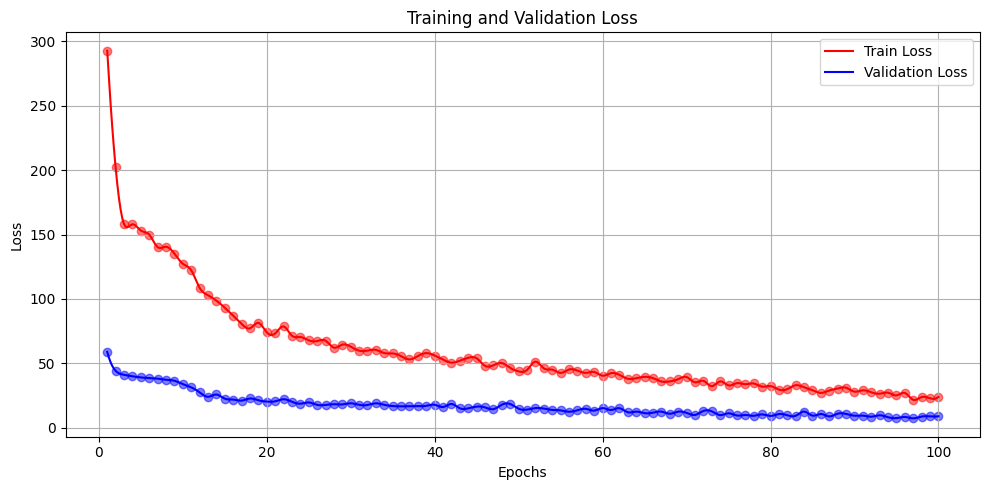

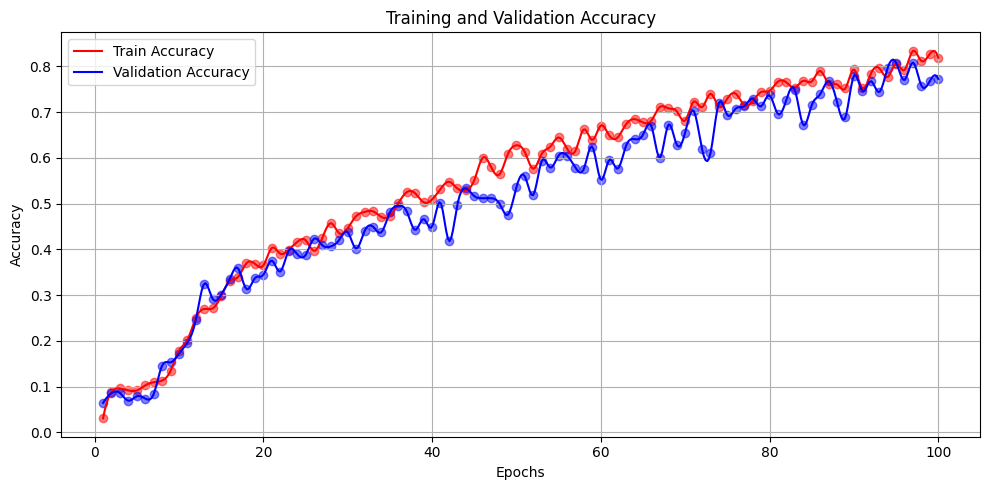

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/sew200/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


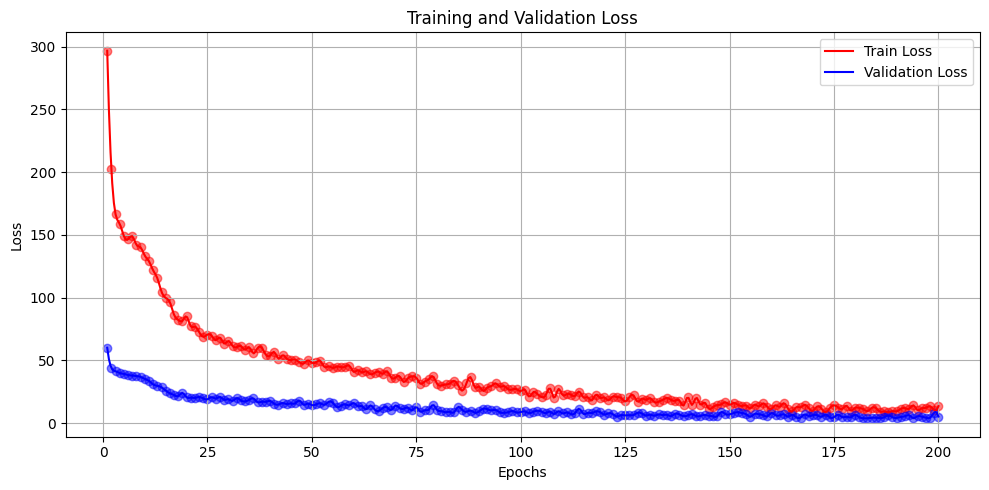

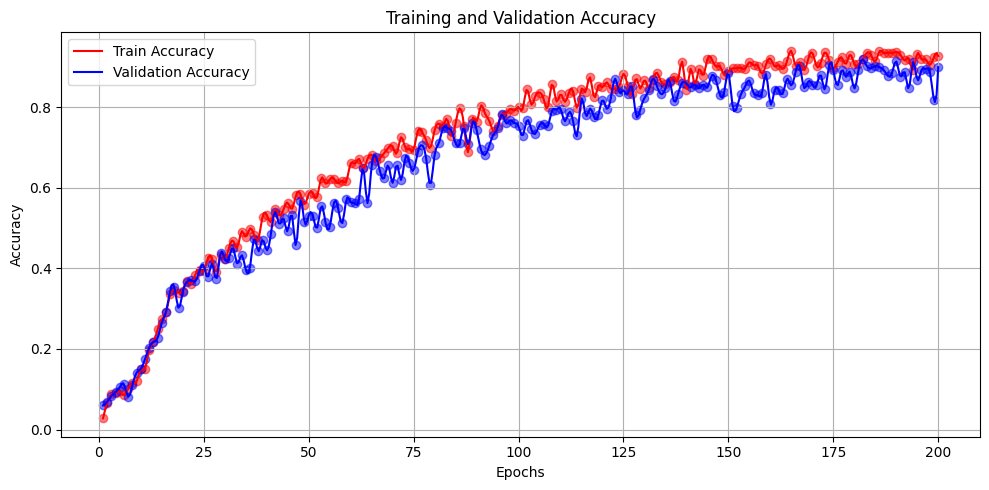

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/sew200/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)
